In [2]:
import os
import sys
import glob
import datetime
import cartopy
import warnings
import zipfile
import fnmatch
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from osgeo import ogr
from shapely.geometry import mapping

from ascat.cgls import SWI_TS
import pygeogrids
import pytesmo.timedate.dekad as dkd
import pytesmo.time_series.anomaly as tsa
import pytesmo.metrics as metrics
import pytesmo.scaling as scaling
import pytesmo.df_metrics as df_metrics
import pytesmo.temporal_matching as temp_match
import ftplib
warnings.filterwarnings('ignore')

#change this path to where data is stored
data_path='/home/mav/ESMCA/Data'
# read shapefiles of GTM 
name='GTM'

gad_1=os.path.join(data_path, 'gadm41_{:}_shp'.format(name), 'gadm41_{:}_1.shp'.format(name))
adm1_list = list(shpreader.Reader(gad_1).geometries())
gad_0=os.path.join(data_path, 'gadm41_{:}_shp'.format(name), 'gadm41_{:}_0.shp'.format(name))
adm0_list = list(shpreader.Reader(gad_0).geometries())
districts=shpreader.Reader(gad_1).records()
districts=[district.attributes['NAME_1'] for district in districts]
geom_dist = {districts[i]: adm1_list[i] for i in range(len(districts))}  
# plotting settings
sns.set(context='paper')
plot_crs = cartopy.crs.Mercator()
data_crs = cartopy.crs.PlateCarree()
extent=[-95,-87,12,19]
# read time series CGLS, which are available as time series already stacked and updated half yearly
ts_io = SWI_TS(os.path.join(data_path, 'SWI_TS'))

# stack of CGLS data to attach NRT data to existing time series
filelist=glob.glob(os.path.join(data_path, 'CGLS','*', '*.nc'))
cgls_stack_slice = xr.open_mfdataset(filelist, engine='rasterio', chunks={}, combine='nested', 
                                     concat_dim='time').sortby('time').sel(x=slice(-95,-87),
                                                                           y=slice(19,12))  
swi_var=['SWI_001','SWI_020']
cgls=cgls_stack_slice[swi_var].compute()
cgls_lon_2d,cgls_lat_2d=np.meshgrid(cgls.x, cgls.y)
grid_cgls=pygeogrids.BasicGrid(cgls_lon_2d.flatten(),cgls_lat_2d.flatten())
cgls_lut=ts_io.grid.calc_lut(grid_cgls)


## stack of C3S data
filelist=glob.glob(os.path.join(data_path, 'C3S', 'images','*.nc'))
c3s_stack_slice = xr.open_mfdataset(filelist, engine='rasterio', chunks={}, combine='nested', 
                              concat_dim='time').sortby('time').sel(x=slice(-95,-87),
                                                                    y=slice(19,12))  
c3s=c3s_stack_slice['sm'].compute()

# create a look up table between the grid of CGLS and C3S for reading the same points
c3s_lon_2d,c3s_lat_2d=np.meshgrid(c3s.x, c3s.y)
grid_c3s=pygeogrids.BasicGrid(c3s_lon_2d.flatten(),c3s_lat_2d.flatten())
c3s_lut=grid.calc_lut(grid_c3s, max_dist=25000)

# create a grid only covering GTM
drv = ogr.GetDriverByName("ESRI Shapefile")
ds_in = drv.Open(gad_0)
lyr_in = ds_in.GetLayer(0)
for feature in lyr_in:
    ply = feature.GetGeometryRef()
    grid=ts_io.grid.get_shp_grid_points(ply)

# create a dictionairy of districts with the CGLS gridpoints falling within that district
districts=[]
gpis=[]
ds_in = drv.Open(gad_1)
lyr_in = ds_in.GetLayer(0)
for feature in lyr_in:
    ply = feature.GetGeometryRef()    
    sgrid=ts_io.grid.get_shp_grid_points(ply)
    districts.append(feature.GetField('Name_1'))
    gpis.append(sgrid.activegpis)
gpi_dist = {districts[i]: gpis[i] for i in range(len(districts))}  

## Reading time series from stack of CGLS images
to read in time series from the CGLS stack we can use the selection method provided by xarray in combination with the time series reader ts_io. We concatenate the time series (cdr) with the image data (icdr) into one time series for the swi variables of choice. Here is is shown per grid point.  

Text(0, 0.5, 'SWI [% saturation]')

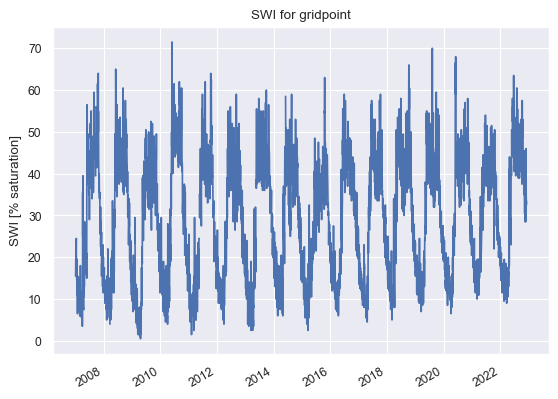

In [3]:
for gpi in grid.activegpis[0:1]:
    lon,lat=grid_cgls.arrlon[cgls_lut[gpi]],grid_cgls.arrlat[cgls_lut[gpi]]
    cdr = ts_io.read(gpi)
    icdr= cgls.sel(x=lon, y=lat).to_dataframe()
    icdr.index=icdr.index.to_datetimeindex()
    df=pd.concat([cdr[swi_var], icdr[swi_var]])
    df[(df>100)|(df<0)] = np.NaN
ax=df['SWI_001'].plot(title='SWI for gridpoint')
ax.set_ylabel("SWI [% saturation]")

## Reading time series from stack of C3S images
to read in time series from the C3S stack we use xarray as time series reader. Here is is shown per grid point.  

Text(0, 0.5, 'SWI [m$^3$m$^-3$]')

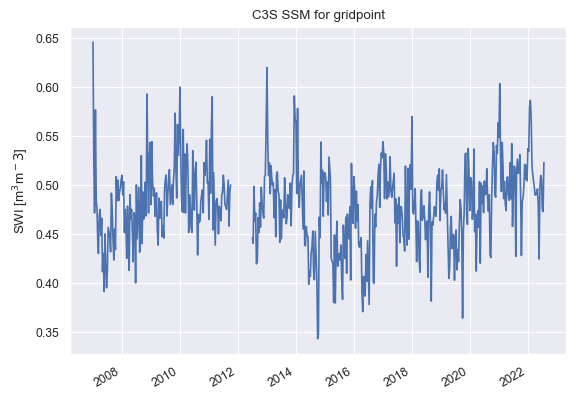

In [4]:
for gpi in grid_c3s.activegpis[100:101]:
    lon,lat=grid_c3s.arrlon[gpi],grid_c3s.arrlat[gpi]
    c3s_ts = c3s.sel(x=lon, y=lat).to_dataframe()
    c3s_ts.index=c3s_ts.index.to_datetimeindex()        
    c3s_ts.loc[(c3s_ts.sm>100)|(c3s_ts.sm<0),'sm'] = np.NaN
ax=c3s_ts['sm'].plot(title='C3S SSM for gridpoint')
ax.set_ylabel(r'SWI [m$^3$m$^-3$]')

## Trend analysis 
Trends can be calculated per grid point, as is done in the first example. We can plot these slope values for every gridpoint for both CGLS and C3S. Here C3S is oversampled to every CGLS gridpoint. 



In [53]:
c3s_ts

,x,y,spatial_ref,sm
2008-07-01,-89.875,17.625,0,79.999992
2008-07-11,-89.875,17.625,0,79.999992
2008-07-21,-89.875,17.625,0,100.000000
2008-08-11,-89.875,17.625,0,0.000000


In [61]:
df_slope=pd.DataFrame(index=grid.activegpis, columns=['cgls_slope', 'c3s_slope'])
for gpi in df_slope.index:
    try:
        lon,lat=grid_cgls.arrlon[cgls_lut[gpi]],grid_cgls.arrlat[cgls_lut[gpi]]
        cdr = ts_io.read(gpi)
        icdr= cgls.sel(x=lon, y=lat).to_dataframe()
        icdr.index=icdr.index.to_datetimeindex()
        df=pd.concat([cdr['SWI_001'], icdr['SWI_001']])
        df[(df>100)|(df<0)] = np.NaN
        df.dropna(inplace=True)
        df_slope.loc[gpi,'cgls_slope'] = np.polyfit(df.index.to_julian_date(), df, 1)[0]

        c3slon,c3slat=grid_c3s.arrlon[c3s_lut[gpi]],grid_c3s.arrlat[c3s_lut[gpi]]
        c3s_ts = c3s.sel(x=c3slon, y=c3slat).to_dataframe()
        c3s_ts.index=c3s_ts.index.to_datetimeindex()        
        c3s_ts.loc[(c3s_ts.sm>1.0)|(c3s_ts.sm<0.0),'sm'] = np.NaN

        c3s_ts.loc[:,'sm'] = ((c3s_ts.loc[:,'sm']-c3s_ts.loc[:,'sm'].min())/(c3s_ts.loc[:,'sm'].max()-c3s_ts.loc[:,'sm'].min()))*100

        c3s_ts = c3s_ts.dropna(subset='sm')
        if len(c3s_ts.sm)>100:
            df_slope.loc[gpi,'c3s_slope'] = np.polyfit(c3s_ts.index.to_julian_date(), c3s_ts['sm'], 1)[0]
    except:
        continue

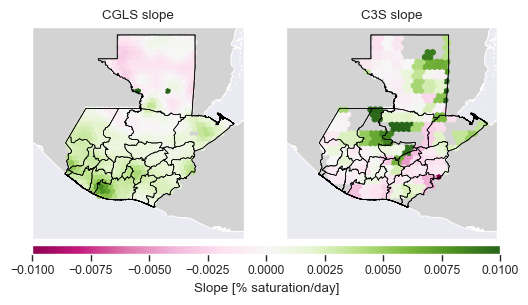

In [62]:
extent=[-93,-88,13,18]

df_slope.loc[:,'lon']=grid.arrlon
df_slope.loc[:,'lat']=grid.arrlat

sns.set_context('paper')
fig, (ax, ax_c3s) = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(6,3), sharex=True, sharey=True)

ax.set_title('CGLS slope')
ax.add_geometries(adm0_list, data_crs,
                  edgecolor='black',linewidth=0.5, facecolor='none', alpha=1.0,zorder=2)
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                    facecolor='lightgray'),zorder=0)
ax.add_geometries(adm1_list, data_crs,
                      edgecolor='black', facecolor='none', linewidth=0.5, alpha=1.0,zorder=2)
ax.add_feature(cartopy.feature.LAND, facecolor='#aaaaaa')
ax.set_extent(extent)
var = df_slope['cgls_slope'].values

sc = ax.scatter(df_slope['lon'], df_slope['lat'], c=var, zorder=1,
                   transform=data_crs, cmap='PiYG',vmin=-0.01, vmax=0.01,s=15)




ax_c3s.set_title('C3S slope')
ax_c3s.add_geometries(adm0_list, data_crs,
                  edgecolor='black',linewidth=0.5, facecolor='none', alpha=1.0,zorder=2)
ax_c3s.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                    facecolor='lightgray'),zorder=0)
ax_c3s.add_geometries(adm1_list, data_crs,
                      edgecolor='black', facecolor='none', linewidth=0.5, alpha=1.0,zorder=2)
ax_c3s.add_feature(cartopy.feature.LAND, facecolor='#aaaaaa')

var = df_slope['c3s_slope'].astype(float).values

sc = ax_c3s.scatter(df_slope['lon'], df_slope['lat'], c=var, zorder=1,
                   transform=data_crs, cmap='PiYG',vmin=-0.01, vmax=0.01,s=15)

cax = fig.add_axes([ax.get_position().x0, ax_c3s.get_position().y0-0.05,
                    0.78, 0.03])
cbar = fig.colorbar(sc, ax=ax, cax=cax,orientation='horizontal')
cbar.set_label('Slope [% saturation/day]')


## District average SWI 
If we want to get the average SWI per district we need to merge different grid points into one. Using the dictionairy we created of district names and gridpoints we can easily do this. We get returned a dataframe with all the gridpoints in the district, and the district average. The gridpoints are the numbered columns, the column with district name is the district average.  

In [70]:
def district_ts(district):
    gpis=gpi_dist[district]
    dummy_dt=pd.date_range(datetime.datetime(2007,1,1),cgls.indexes['time'].to_datetimeindex()[-1])
    cgls_df=pd.DataFrame(index=dummy_dt, columns=pd.MultiIndex.from_product([['SWI_001','SWI_020'],gpis]))
    for gpi in gpis:
        lon,lat=grid_cgls.arrlon[cgls_lut[gpi]],grid_cgls.arrlat[cgls_lut[gpi]]
        cdr = ts_io.read(gpi)
        icdr= cgls.sel(x=lon, y=lat).to_dataframe()
        icdr.index=icdr.index.to_datetimeindex()
        df=pd.concat([cdr[swi_var], icdr[swi_var]])
        df[(df>100)|(df<0)] = np.NaN
        cgls_df.loc[:,('SWI_001', gpi)]=df['SWI_001'].values
        cgls_df.loc[:,('SWI_020', gpi)]=df['SWI_020'].values
    cgls_df.loc[:,('SWI_001', district)] = cgls_df.xs('SWI_001',level=0, axis=1).median(axis=1)
    cgls_df.loc[:,('SWI_020', district)] = cgls_df.xs('SWI_020',level=0, axis=1).median(axis=1)
    return cgls_df

district='Zacapa'
cgls_df=district_ts(district)


## Anomalies and absolute values plotting 
plotting the district average soil moisture absolute and anomalies can be done using the pytesmo package


(17897.0, 19357.0)

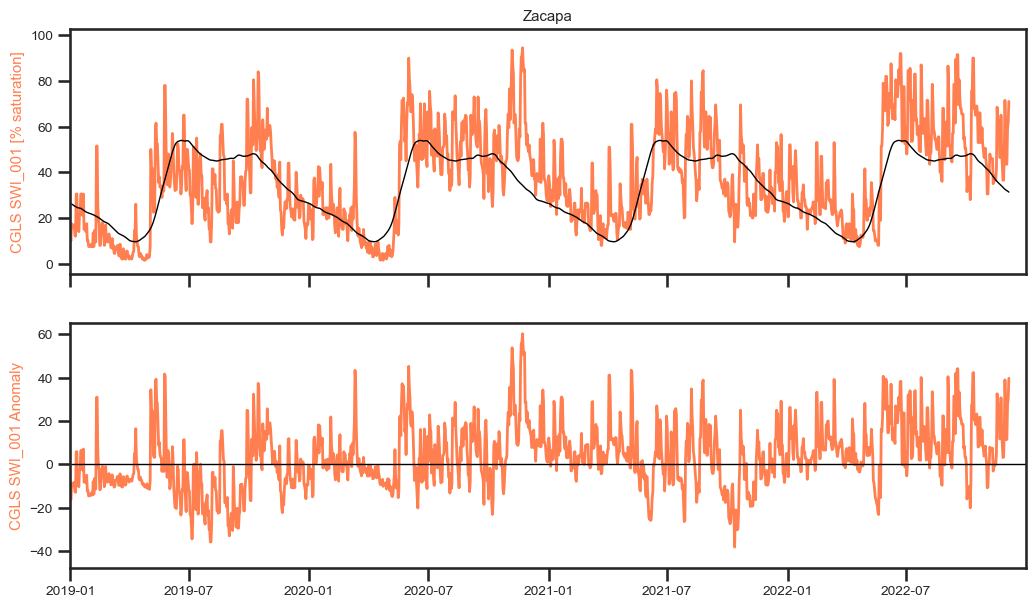

In [71]:
var='SWI_001'
sns.set(context='talk', style='ticks', font_scale=0.6)
clim = tsa.calc_climatology(cgls_df[var][district], respect_leap_years=True, wraparound=True)
anomaly = tsa.calc_anomaly(cgls_df[var][district], climatology=clim, respect_leap_years=True)                  
cgls_df.loc[:,(var, 'clim')] = clim[cgls_df.index.dayofyear].values
_, (ax1, ax2) = plt.subplots(2,1, figsize=(12.33, 7), sharex=True)
ax1.plot(cgls_df[var][district], c='coral', lw=2)
ax1.plot(cgls_df[var]['clim'], c='black', lw=1)
ax1.set_ylabel('CGLS {:} [% saturation]'.format(var), c='coral')
ax2.plot(anomaly, c='coral', lw=2)
ax2.set_ylabel('CGLS {:} Anomaly'.format(var), c='coral')
ax2.axhline(0,c='black', lw=1)
ax1.set_title(district)
ax1.set_xlim(datetime.datetime(2019, 1, 1), datetime.datetime(2022, 12, 31)) 


## Trend per district
We have seen some trends in the CGLS and C3S data. But we do not know what is causing these trends. To assess if trends are observed in the data which are not natural, i.e. not a result of increasing precipitation or decreased evaporation, but because of changes in backscatter due to changes in land use, we can compare trends between rainfall and soil moisture. 
First we read chirps data per district. Next, this needs to be merged with the soil moisture data. Chirps data is in dekadal resolution, soil moisture in daily. We calculate monthly means from both. After this we can analyse trends. 

In [65]:
def chirps_per_district(districts):
    filelist = np.sort(glob.glob(os.path.join(data_path, 'CHIRPS', '*.tif')))
    dt=[datetime.datetime.strptime(x[-13:-5]+str(int(x[-5:-4])*7),'%Y.%m.%d') for x in filelist]
    dfr = pd.DataFrame(index=dt, columns=districts)
    for ix, fname in zip(dt,filelist): 
        dset = rxr.open_rasterio(fname).squeeze()
        for district in districts:
            geometry=geom_dist[district]
            dataset = dset.rio.clip([geometry])
            dfr.loc[ix,district] =np.nanmedian(dataset)
    return dfr
dfr=chirps_per_district(districts)



In [68]:
district='Retalhuleu'
var='SWI_001'
cgls_df=district_ts(district)
dfm=cgls_df.resample('m').mean()#
dfm.loc[:, ('RF', district)] = dfr[district].resample('m').sum().astype(float)
dfm = dfm.dropna(subset=[('RF', district), ('SWI_001', district)])
jd = dfm.index.to_julian_date()
swifit=np.polyfit(jd, dfm.loc[:, (var, district)],1)
rffit=np.polyfit(jd, dfm.loc[:, ('RF', district)],1)

Text(0.5, 1.0, 'Retalhuleu')

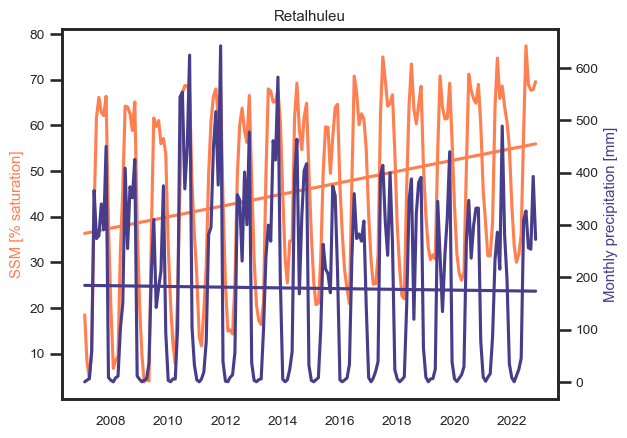

In [69]:
sns.set_style('white')
_,ax=plt.subplots()
ax1=ax.twinx()
ax.plot(dfm.index, dfm[(var, district)],c='coral')
ax1.plot(dfm.index, dfm[('RF', district)],c='darkslateblue')
ax.plot(dfm.index, swifit[0]*jd+swifit[1],c='coral')
ax1.plot(dfm.index, rffit[0]*jd+rffit[1],c='darkslateblue')
ax.set_ylabel('SSM [% saturation]')
ax.yaxis.label.set_color('coral')
ax1.set_ylabel('Monthly precipitation [mm]')
ax1.yaxis.label.set_color('darkslateblue')
ax.set_title(district)